#### to investigate the effects of scaling and weights-balancing, using the most straight-forward model
* logR is a good starting point, as it is straight-forward to implement, without the need the investigate hyperparameters
* we study the effects of scaling (without, with `StandardScalar()`, or with `MinMaxScalar` as we observed the different features have values that span different orders of magnitudes
* we study the effects of weights using class_weights = "balanced" as there is imbalanced yes (88%) and no (12%) class

In [1]:
# import libraries to facilitate calculations and data prep
import os
import math
import pandas as pd
import numpy as np

In [2]:
# load previously process data

trainX_path = "./trainX_dropped.csv"
trainY_path = "./trainY_dropped.csv" 
testX_path = "./testX.csv" 
testY_path = "./testY.csv" 

df_trainX = pd.read_csv(trainX_path)
df_trainY = pd.read_csv(trainY_path)
df_testX = pd.read_csv(testX_path)
df_testY = pd.read_csv(testY_path)

trainX, testX, trainY, testY = df_trainX, df_testX, df_trainY['oh_y_yes'], df_testY['oh_y_yes']

In [3]:
# import libraries needed to perform learning
from sklearn.linear_model import LogisticRegression

# import libraries to evaluate models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#### First attemt with LogR with *no* scaling or weights-balancing ####
* model is largely making "no" predictions, as indicated by low recall and f1 scores for the 'no' class

              precision    recall  f1-score   support

           n       0.89      1.00      0.94      7984
           y       0.92      0.09      0.17      1058

    accuracy                           0.89      9042
   macro avg       0.90      0.55      0.56      9042
weighted avg       0.90      0.89      0.85      9042



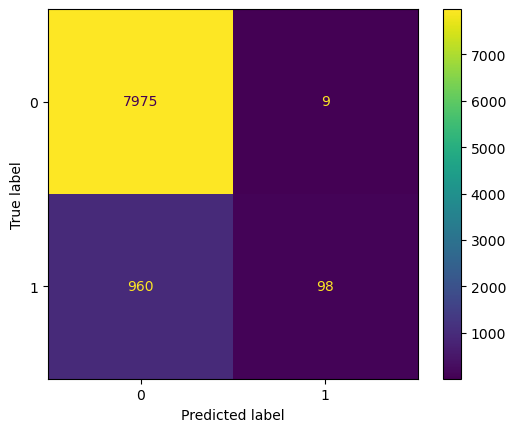

In [4]:
regressor = LogisticRegression(max_iter=1e5)
regressor.fit(trainX,trainY)
y_hat_train = regressor.predict(trainX)
y_hat_test = regressor.predict(testX)

cm = confusion_matrix(testY, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(testY, y_hat_test, target_names=['n','y']))

#### we next investigate the effects of scaling and weight-balancing
* we observed that balancing weights have a bigger impact on improving prediction than scaling has

In [5]:
## scale data - investigate effects of scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# define a function to output precision, recall, and f1 score for the 'yes' class
def evaluate(model, x_train, x_test, y_train, y_test):
    
    # function takes the regressor, x_train, and y_train, train model
    model.fit(X=x_train,y=y_train)
    # define variables to hold the predicted values
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    
    # Evaluate and print metrics
    metrics = [f'{precision_score(y_test, y_hat_test):.2f}', 
               f'{recall_score(y_test, y_hat_test):.2f}',
               f'{f1_score(y_test, y_hat_test):.2f}',
               f'{accuracy_score(y_test, y_hat_test):.2f}']
    
    print(metrics)

In [6]:
import time
start_time = time.time()

model = LogisticRegression(max_iter=1e5)
evaluate(model,
         x_train = trainX, x_test = testX,
         y_train = trainY, y_test = testY)
end_time = time.time()
print(end_time - start_time)

['0.92', '0.09', '0.17', '0.89']
11.934130907058716


In [7]:
import time
start_time = time.time()

# define models for training
models = [LogisticRegression(max_iter=1e5), LogisticRegression(max_iter=1e5, class_weight = 'balanced')]

# transform data for training; libraries should have been imported in previous cells  
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
trainX_data = [trainX, std_scaler.fit_transform(trainX), min_max_scaler.fit_transform(trainX)]              
# testX_data = [testX, std_scaler.fit_transform(testX), min_max_scaler.fit_transform(testX)]
    # for test data, should use .transform instead of .fit_transform
    # this re-uses the same mean/std that was obtained from doing fit_transform on train data
testX_data = [testX, std_scaler.transform(testX), min_max_scaler.transform(testX)]

for model in models:
    for i in range(0,len(trainX_data)):
        evaluate(model=model, 
         x_train = trainX_data[i], x_test = testX_data[i],
         y_train = trainY, y_test = testY)
end_time = time.time()
print(end_time - start_time)

['0.92', '0.09', '0.17', '0.89']
['0.93', '0.08', '0.15', '0.89']
['0.93', '0.06', '0.12', '0.89']
['0.85', '0.55', '0.66', '0.94']
['0.87', '0.54', '0.67', '0.94']
['0.89', '0.50', '0.64', '0.93']
22.603621006011963


#### both scaling and weights-balancing have significant impact on model peformance
* scaling can drastically improve performance even in the absence of weights-balancing (between lines 1 vs 2)
* weights-balancing is important; significantly improves performance, even in the absence of scaling (line 4 vs 1-3)
    * scaling is still needed (lines 5-6 vs 1) but impact on choice of scaler is less significant

#### we display the results with the "best" model
* `MinMaxScalar()` 
* `class_weight = 'balanced'`

              precision    recall  f1-score   support

           n       0.98      0.96      0.97      7984
           y       0.75      0.84      0.79      1058

    accuracy                           0.95      9042
   macro avg       0.86      0.90      0.88      9042
weighted avg       0.95      0.95      0.95      9042



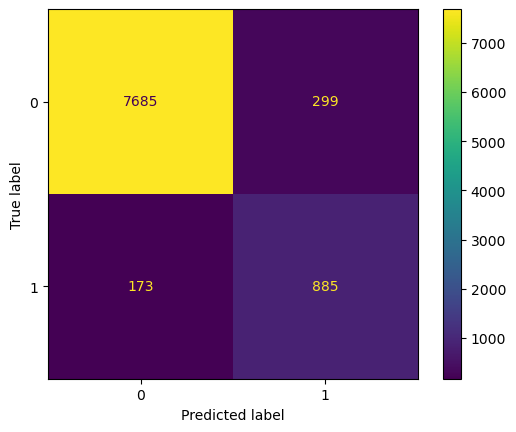

In [8]:
regressor = LogisticRegression(max_iter=1e5, class_weight = 'balanced')
regressor.fit(min_max_scaler.fit_transform(trainX),trainY)
y_hat_train = regressor.predict(min_max_scaler.fit_transform(trainX))
y_hat_test = regressor.predict(min_max_scaler.fit_transform(testX))

cm = confusion_matrix(testY, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(testY, y_hat_test, target_names=['n','y']))

#### Revisiting decision to drop the outlier data point ####
* we re-train the model with original set of data, and saw that the inclusion of outlier did not impact the model performance when appropriate scaling/weight-balancing was performed
* in fact, when weights-balancing was carried out, scaling had *NO impact on the model*. This was to be expected, as weights-balancing and scaling achieve the same effect of applying penaly (in weights balancing) or reducing impact (via scaling).

Moreover, we saw that in this case, the *LogR model can be considered outlier-robust*
* this was important as it reduces the effort required to pre-prune data prior to using them

In [9]:
# load processed data that included the outlier
trainX_path = "./trainX.csv"
trainY_path = "./trainY.csv" 
df_trainX = pd.read_csv(trainX_path)
df_trainY = pd.read_csv(trainY_path)

trainX, testX, trainY, testY = df_trainX, df_testX, df_trainY['oh_y_yes'], df_testY['oh_y_yes']

              precision    recall  f1-score   support

           n       0.92      1.00      0.95      7984
           y       0.90      0.31      0.46      1058

    accuracy                           0.91      9042
   macro avg       0.91      0.65      0.71      9042
weighted avg       0.91      0.91      0.90      9042



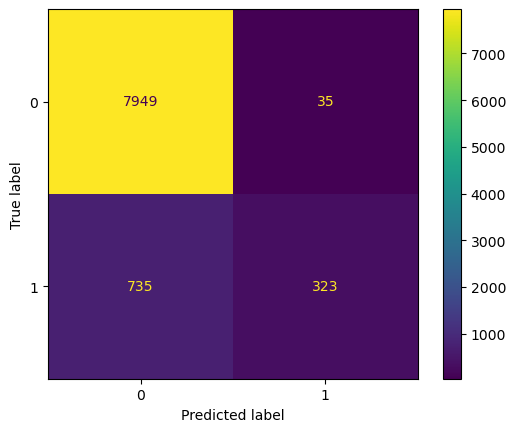

In [10]:
regressor = LogisticRegression(max_iter=1e5)
regressor.fit(trainX,trainY)
y_hat_train = regressor.predict(trainX)
y_hat_test = regressor.predict(testX)

cm = confusion_matrix(testY, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(testY, y_hat_test, target_names=['n','y']))

In [11]:
import time
start_time = time.time()

# define models for training
models = [LogisticRegression(max_iter=1e5), LogisticRegression(max_iter=1e5, class_weight = 'balanced')]

# transform data for training; libraries should have been imported in previous cells  
trainX_data = [trainX, std_scaler.fit_transform(trainX), min_max_scaler.fit_transform(trainX)]              
testX_data = [testX, std_scaler.transform(testX), min_max_scaler.transform(testX)]

for model in models:
    for i in range(0,len(trainX_data)):
        evaluate(model=model, 
         x_train = trainX_data[i], x_test = testX_data[i],
         y_train = trainY, y_test = testY)
end_time = time.time()
print(end_time - start_time)

['0.90', '0.31', '0.46', '0.91']
['0.90', '0.30', '0.45', '0.91']
['0.91', '0.26', '0.40', '0.91']
['0.77', '0.82', '0.79', '0.95']
['0.76', '0.82', '0.79', '0.95']
['0.78', '0.80', '0.79', '0.95']
23.948723793029785


#### we display the results with the "best" model trained with outlier
* no scaling
* `class_weight = 'balanced`

              precision    recall  f1-score   support

           n       0.98      0.97      0.97      7984
           y       0.77      0.82      0.79      1058

    accuracy                           0.95      9042
   macro avg       0.87      0.89      0.88      9042
weighted avg       0.95      0.95      0.95      9042



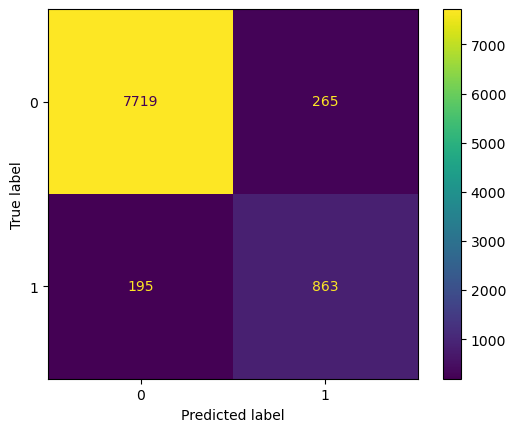

In [12]:
regressor = LogisticRegression(max_iter=1e5, class_weight = 'balanced')
regressor.fit(trainX,trainY)
y_hat_train = regressor.predict(trainX)
y_hat_test = regressor.predict(testX)

cm = confusion_matrix(testY, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(testY, y_hat_test, target_names=['n','y']))

#### LogR Review observations, conclusions, and follow up
* quick and easy, weights-balancing _needs_ to be done
* effects of scaling as to be invesitgated
* LogR is outlier-robust in this case

#### We next turn to SVM, to assess if it could be more efficient. 
* once model is trained, testign requires only the support vectors